In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import networkx as nx


In [3]:
# グラフの構築
G = nx.karate_club_graph()

#ノード数とエッジ数を出力
nx.number_of_nodes(G), nx.number_of_edges(G)

(34, 78)

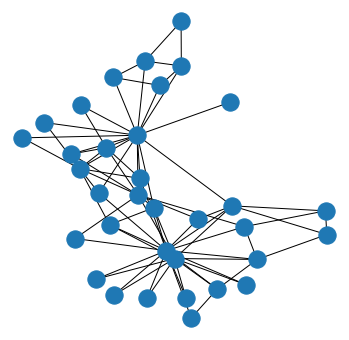

In [4]:
# networkx, matplotlib の import
import networkx as nx
import matplotlib.pyplot as plt

# グラフの構築
G = nx.karate_club_graph()

# レイアウトの取得
pos = nx.spring_layout(G)

# 可視化
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos)
plt.axis('off')
plt.show()

## 一旦nxは使わずにデータを扱ってみる

In [5]:
from collections import defaultdict
nodes = list(G.nodes())
labels = []
neighbors = []
edges = []
edge_dict = defaultdict(list)
for node in nodes:
    neig = list(G.neighbors(node))
    neighbors.append(neig)
    label = G.nodes[node]["club"]
    labels.append(label)
    for nei in neig:
        if node < nei:
            edges.append([node, nei])
        edge_dict[node].append(nei)
    print("node : {}, num edge : {}, label : {}".format(node, len(neig), label))
labels = (np.array(labels) == "Officer").astype(int)

node : 0, num edge : 16, label : Mr. Hi
node : 1, num edge : 9, label : Mr. Hi
node : 2, num edge : 10, label : Mr. Hi
node : 3, num edge : 6, label : Mr. Hi
node : 4, num edge : 3, label : Mr. Hi
node : 5, num edge : 4, label : Mr. Hi
node : 6, num edge : 4, label : Mr. Hi
node : 7, num edge : 4, label : Mr. Hi
node : 8, num edge : 5, label : Mr. Hi
node : 9, num edge : 2, label : Officer
node : 10, num edge : 3, label : Mr. Hi
node : 11, num edge : 1, label : Mr. Hi
node : 12, num edge : 2, label : Mr. Hi
node : 13, num edge : 5, label : Mr. Hi
node : 14, num edge : 2, label : Officer
node : 15, num edge : 2, label : Officer
node : 16, num edge : 2, label : Mr. Hi
node : 17, num edge : 2, label : Mr. Hi
node : 18, num edge : 2, label : Officer
node : 19, num edge : 3, label : Mr. Hi
node : 20, num edge : 2, label : Officer
node : 21, num edge : 2, label : Mr. Hi
node : 22, num edge : 2, label : Officer
node : 23, num edge : 5, label : Officer
node : 24, num edge : 3, label : Officer


## グラフラプラシアンを用いたクラスタリング

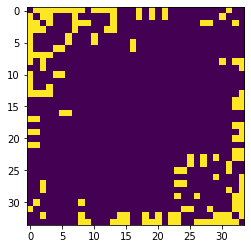

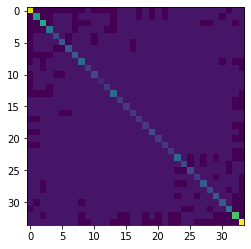

In [6]:
## edge matrix
n_node = len(nodes)
edge_matrix = np.zeros([n_node, n_node])
for edge in edges:
    edge_matrix[edge[0], edge[1]] = 1
    edge_matrix[edge[1], edge[0]] = 1
plt.imshow(edge_matrix)
plt.show()

## graph laplacian
degree_matrix = np.diag(np.sum(edge_matrix, axis = 1))
graph_laplacian = degree_matrix - edge_matrix
plt.imshow(graph_laplacian)

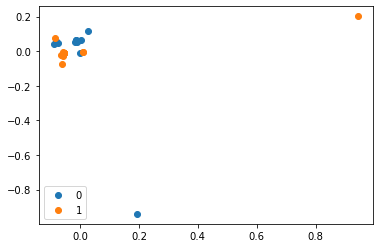

In [7]:
## 固有値分解
lam, eig_vec = np.linalg.eig(graph_laplacian)
eig_vec = eig_vec[:,:2]
idx = labels == 0
plt.scatter(eig_vec[idx, 0], eig_vec[idx, 1], label = 0)
idx = labels == 1
plt.scatter(eig_vec[idx, 0], eig_vec[idx, 1], label = 1)
plt.legend()


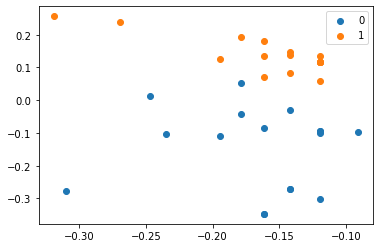

In [8]:
# ノーマライズバージョン
std1 = np.std(graph_laplacian, axis = 0, keepdims = True)
std2 = np.std(graph_laplacian, axis = 1, keepdims = True)
lam, eig_vec = np.linalg.eig(graph_laplacian / np.sqrt(std1) / np.sqrt(std2))
eig_vec = eig_vec[:,:2]
idx = labels == 0
plt.scatter(eig_vec[idx, 0], eig_vec[idx, 1], label = 0)
idx = labels == 1
plt.scatter(eig_vec[idx, 0], eig_vec[idx, 1], label = 1)
plt.legend()


## deep walk

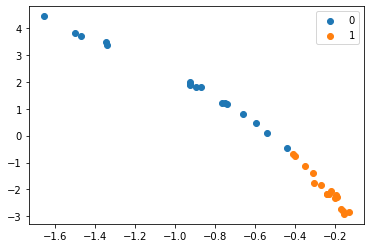

In [9]:
def get_path(edge_dict, path_length, n_path):
    pathes = []
    for _ in range(n_path):
        node = int(np.random.choice(list(edge_dict.keys())))
        path = [str(node)]
        for _ in range(n_path - 1):
            node = np.random.choice(edge_dict[node])
            path.append(str(node))
        pathes.append(path)
    return pathes

from gensim.models import Word2Vec as word2vec
pathes = get_path(edge_dict, path_length = 500, n_path = 500) ## get pathes
model = word2vec(pathes, min_count = 1, size = 2, window = 5) ## train word2vec

## get vecs
deep_walk_vecs = []
for node in nodes:
    deep_walk_vecs.append(model.wv[str(node)])
deep_walk_vecs = np.array(deep_walk_vecs)

## plot
idx = labels == 0
plt.scatter(deep_walk_vecs[idx, 0], deep_walk_vecs[idx, 1], label = 0)
idx = labels == 1
plt.scatter(deep_walk_vecs[idx, 0], deep_walk_vecs[idx, 1], label = 1)
plt.legend()